In [1]:
import numpy as np

import sys
import os

os.environ['TOOLBOX_PATH'] = "/PATH/TO/BART/"
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python/")
sys.path.append("PATH/TO/TOOLS/")

import struct
import cfl

from copy import deepcopy

from matplotlib import pyplot as plt
from matplotlib import lines as lines
from matplotlib import colors as col
from matplotlib import patches as patches
%matplotlib inline

import toolbox as tools

import pickle5 as pickle
import skimage
import nibabel as nib

## Recon Settings

In [2]:
# General settings

save_folder = 'Saved_Recon_Data/Regularization_Results/'

volunteer_num = 1
scan = 'BFFE' # 'GRE'
FB = False

use_adjoint = True
correct_shifted_difference = True

reg = 'LLR'
reg_param = [0.00001,0.00002,0.00005,0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2]

## Cardiac Binning Settings

card_phases = 25

## Resp Binning Settings

resp_binning = True
resp_phases = 5
resp_bin_subset = None#np.arange(5,

In [3]:
# Additional default settings
num_coils = 6
TR = 4.5

if FB:
    scan_shape = [352, 20000]
else:
    scan_shape = [352, 3000]
    resp_binning = False

In [4]:
# Filepath stuff

file_path = '/scratch/mcgrath/BFlow/Data/031122/cv_0' + str(volunteer_num) + '/'

if scan=='GRE':
    if FB:
        file_path = file_path + 'flash_cv_sl_1_6mm_7mm_TR4_5_uTGA_FB/'
    else:
        file_path = file_path + 'flash_cv_sl_1_6mm_7mm_TR4_5_uTGA/'
    savefilename  = 'reg_GRE_cv'+str(volunteer_num)
else:
    if FB:
        file_path = file_path + 'bssfp_fl_1_6mm_7mm_TR4_5_uTGA7_FB/'
    else:
        file_path = file_path + 'bssfp_fl_1_6mm_7mm_TR4_5_uTGA7/'
    savefilename  = 'reg_BFFE_cv'+str(volunteer_num)
    
if FB:
    savefilename = savefilename + '_FB'
    
savefilename = savefilename + '_' + reg

In [5]:
# Custome per-subject settings

# Default plotting and image alignment settings
rot_angle = 90
gifprctile = 98
flip_x = False
flip_y = True

# Default binning settings 
f_lowpass_card = 1.2
f_highpass_card = 0.8
f_lowpass_resp = 0.4
f_highpass_resp = None
card_trim = 0
resp_trim = 0
card_thresh = 0.5
resp_thresh = 0.4
flip_card_signal = False
reject_close_peaks = False
reject_close_peaks_resp = False
expected_HR = None

res_shift = 0

if scan=='BFFE':
    
    if volunteer_num==1:
        f_lowpass_card = 4
        f_highpass_card = 0.2
        card_trim = 3
        card_thresh = 0.5
        flip_card_signal = False
        reject_close_peaks = True
        expected_HR = None
        res_shift = 1
        
        
        if resp_binning:
            card_thresh = 0.7
            card_trim=4
            resp_thresh=0.7
            res_shift = 0

    
    if volunteer_num==2:
        f_lowpass_card = 4
        f_highpass_card = 0.15
        card_trim = 1
        card_thresh = 0.4
        flip_card_signal = False
        reject_close_peaks = True
        expected_HR = 65

        
#         if resp_binning:


    if volunteer_num==3:
        f_lowpass_card = 4
        f_highpass_card = 0.15
        card_trim = 1
        card_thresh = 0.4
        flip_card_signal = False
        reject_close_peaks = True
        expected_HR = 60

#         if resp_binning:


    if volunteer_num==4:
        f_lowpass_card = 4
        f_highpass_card = 0.2
        card_trim = 1
        card_thresh = 0.4
        flip_card_signal = False
        reject_close_peaks = True
        expected_HR = 75

        
#         if resp_binning:

            

    if volunteer_num==5:
        f_lowpass_card = 4
        f_highpass_card = 0.3
        card_trim = 5
        card_thresh = 0.2
        flip_card_signal = False
        reject_close_peaks = True
        expected_HR = 48

        
#         if resp_binning:

            
if scan=='GRE':
    
    if volunteer_num==1:
        f_lowpass_card = 4
        f_highpass_card = 0.15
        card_trim = 4
        card_thresh = 0.4
        flip_card_signal = False
        reject_close_peaks = True
        expected_HR = None
        
#         if resp_binning:

    
    if volunteer_num==2:
        f_lowpass_card = 4
        f_highpass_card = 0.15
        card_trim = 1
        card_thresh = 0.4
        flip_card_signal = False
        reject_close_peaks = True
        expected_HR = 65

        
#         if resp_binning:



    if volunteer_num==3:
        f_lowpass_card = 4
        f_highpass_card = 0.15
        card_trim = 1
        card_thresh = 0.4
        flip_card_signal = False
        reject_close_peaks = True
        expected_HR = 60

#         if resp_binning:


    if volunteer_num==4:
        f_lowpass_card = 4
        f_highpass_card = 0.2
        card_trim = 1
        card_thresh = 0.4
        flip_card_signal = False
        reject_close_peaks = True
        expected_HR = 75

        
#         if resp_binning:

            

    if volunteer_num==5:
        f_lowpass_card = 4
        f_highpass_card = 0.3
        card_trim = 2
        card_thresh = 0.2
        flip_card_signal = False
        reject_close_peaks = True
        expected_HR = 51

        
#         if resp_binning:



        

In [6]:
fp = file_path + 'KX_E00_P00.dat'
f = open(fp,'rb')
kx0 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

fp = file_path + 'KY_E00_P00.dat'
f = open(fp,'rb')
ky0 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

fp = file_path + 'KZ_E00_P00.dat'
f = open(fp,'rb')
kz0 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

fp = file_path + 'KW_E00_P00.dat'
f = open(fp,'rb')
kw0 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

fp = file_path + 'KX_E00_P01.dat'
f = open(fp,'rb')
kx1 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

fp = file_path + 'KY_E00_P01.dat'
f = open(fp,'rb')
ky1 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

fp = file_path + 'KZ_E00_P01.dat'
f = open(fp,'rb')
kz1 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

fp = file_path + 'KW_E00_P01.dat'
f = open(fp,'rb')
kw1 = np.reshape(np.fromfile(f, dtype=np.float32),scan_shape,'F')
f.close()

# rotation correction

kxn0 = np.cos(rot_angle*np.pi/180)*kx0 - np.sin(rot_angle*np.pi/180)*ky0
ky0 = np.sin(rot_angle*np.pi/180)*kx0 + np.cos(rot_angle*np.pi/180)*ky0
kx0=kxn0

kxn1 = np.cos(rot_angle*np.pi/180)*kx1 - np.sin(rot_angle*np.pi/180)*ky1
ky1 = np.sin(rot_angle*np.pi/180)*kx1 + np.cos(rot_angle*np.pi/180)*ky1
kx1=kxn1

#flipping

if flip_x:
    kx0=-kx0
    kx1=-kx1
if flip_y:
    ky0=-ky0
    ky1=-ky1

In [7]:
max_k_0 = np.maximum(np.max(kx0),np.max(ky0))
max_k_1 = np.maximum(np.max(kx1),np.max(ky1))

k = (np.sum(np.sqrt(kx0**2 + ky0**2),1)/np.shape(kx0)[1])
dk = k[-1] - k[-2]

## Load Kspace Data

In [8]:

kspace0 = np.zeros([scan_shape[0],scan_shape[1],num_coils],dtype=np.complex64)
k0_0 = np.zeros([scan_shape[1],num_coils],dtype=np.complex64);

kspace1 = np.zeros([scan_shape[0],scan_shape[1],num_coils],dtype=np.complex64)
k0_1 = np.zeros([scan_shape[1],num_coils],dtype=np.complex64);
    
for c in range(num_coils):
    
    fp = file_path + 'KDATA_C' + f'{c:02d}' + '_E00_P00.dat'
    f = open(fp,'rb')
    data = np.reshape(np.fromfile(f, dtype=np.float32),[2,scan_shape[0],scan_shape[1]],'F')
    data = np.squeeze(data[0,:,:] + 1j*data[1,:,:])
    kspace0[:,:,c] = data
    k0_0[:,c] = np.squeeze(tools.binning.get_k0(data,kx0,ky0))
    
    fp = file_path + 'KDATA_C' + f'{c:02d}' + '_E00_P01.dat'
    f = open(fp,'rb')
    data = np.reshape(np.fromfile(f, dtype=np.float32),[2,scan_shape[0],scan_shape[1]],'F')
    data = np.squeeze(data[0,:,:] + 1j*data[1,:,:])
    kspace1[:,:,c] = data
    k0_1[:,c] = np.squeeze(tools.binning.get_k0(data,kx1,ky1))
    
kspace0 = kspace0[np.newaxis,...]
kspace1 = kspace1[np.newaxis,...]

## Reconstruct Full Series Coil Images

In [9]:
kb0 = np.stack([kx0,ky0,kz0],0)
kb0 = kb0[...,np.newaxis]

kb0 = kb0/dk

kb1 = np.stack([kx1,ky1,kz1],0)
kb1 = kb1[...,np.newaxis]

kb1 = kb1/dk

In [10]:
# Write CFL files
cfl.writecfl('bart_cfl/kcoord0', kb0)
cfl.writecfl('bart_cfl/kspace0',kspace0)

cfl.writecfl('bart_cfl/kcoord1', kb1)
cfl.writecfl('bart_cfl/kspace1',kspace1)

In [11]:
cfl.writecfl('bart_cfl/kcoordsens',np.concatenate([kb0,kb1],axis=2))
cfl.writecfl('bart_cfl/kspacesens',np.concatenate([kspace0,kspace1],axis=2))

In [12]:
! bart rss 1 bart_cfl/kcoordsens bart_cfl/kb_rss
! bart fmac bart_cfl/kspacesens bart_cfl/kb_rss bart_cfl/ksp_weighted

! bart nufft -i -g -t bart_cfl/kcoordsens bart_cfl/kspacesens bart_cfl/full_nufft
! bart nufft -a -g -t bart_cfl/kcoordsens bart_cfl/ksp_weighted bart_cfl/adjoint_nufft

if use_adjoint:
    nufft_data = cfl.readcfl('bart_cfl/adjoint_nufft')
else:
    nufft_data = cfl.readcfl('bart_cfl/full_nufft')
sos = np.sqrt(np.sum(np.abs(nufft_data)**2,3))[...,np.newaxis]
nufft_data = nufft_data/sos
cfl.writecfl('bart_cfl/full_nufft',nufft_data)

! bart fft 3 bart_cfl/full_nufft bart_cfl/full_cart_ksp
#! bart ecalib -m1 -a bart_cfl/full_cart_ksp bart_cfl/sens
! bart caldir 5 bart_cfl/full_cart_ksp bart_cfl/sens


Est. image size: 352x352x1
Done.
Est. image size: 352x352x1
Done.
Calibration region 5x5x1
Done.


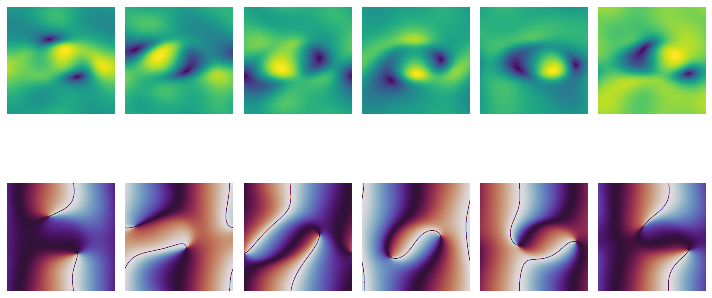

In [13]:
sens = cfl.readcfl('bart_cfl/sens')

row = int(np.ceil(num_coils/6))
plt.close('all')

f, a = plt.subplots(2*row, 6, figsize=(10,3*2*row))

for coil in range(num_coils):
    
    c = np.mod(coil,6)
    r = int(np.floor(coil/6))*2
    
    a[r,c].imshow(np.abs(np.squeeze(sens[:,:,:,coil])))
    a[r+1,c].imshow(np.angle(np.squeeze(sens[:,:,:,coil])),vmin=-np.pi, vmax = np.pi,cmap='twilight')
    
[_.axis("off") for _ in a.flatten()];
f.tight_layout()

In [14]:
! bart pics -g -d3 -i10 S -t bart_cfl/kcoordsens bart_cfl/kspacesens bart_cfl/sens bart_cfl/output 

GPU reconstruction
[  1 352 6000   6   1   1   1   1   1   1   1   1   1   1   1   1 ]
[352 352   1   6   1   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 352 6000   6   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [352 352   1   6   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 352 6000   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
Allocating 2112000 (vs. 2607616) + 495616
ksp : [  1 352 6000   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [704 704   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 352 6000   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 0.029542  (max = 0.062823/p90 = 0.029542/median = 0.011735)
Inverse scaling of the data: 0.029542
Regularization terms: 0, Supporting variables: 0
conjugate gradients
lsqr: add GPU wrapper
GPU start.
GPU end.
Total Time: 3.310370


In [15]:
result = cfl.readcfl('bart_cfl/output')

thresh = np.max(np.squeeze(np.abs(result))[:50,:50])
mask = np.squeeze(np.abs(result))>thresh
mask = skimage.morphology.remove_small_objects(mask)
mask = skimage.morphology.dilation(mask,skimage.morphology.disk(3))
mask = skimage.morphology.remove_small_holes(mask,10000)


mask_phasecor = np.squeeze(np.abs(result))>(thresh*1.2)
mask_phasecor = skimage.morphology.remove_small_objects(mask_phasecor)
mask_phasecor = skimage.morphology.remove_small_objects(mask_phasecor)
mask_phasecor = skimage.morphology.opening(mask_phasecor,skimage.morphology.disk(5))

lmax = np.percentile(abs(result),99)

plt.close('all')
f, a = plt.subplots(1, 4, figsize=(12, 4))

a[0].imshow(np.abs(np.squeeze(result[:,:])),vmin=0, vmax = lmax)
a[0].get_xaxis().set_visible(False)
a[0].get_yaxis().set_visible(False)
a[0].set_title("Magnitude")

a[1].imshow(np.angle(np.squeeze(result[:,:])),vmin=-np.pi, vmax = np.pi)
a[1].get_xaxis().set_visible(False)
a[1].get_yaxis().set_visible(False)
a[1].set_title("Phase");

a[2].imshow(mask)
a[2].get_xaxis().set_visible(False)
a[2].get_yaxis().set_visible(False)
a[2].set_title("Mask");

a[3].imshow(mask_phasecor)
a[3].get_xaxis().set_visible(False)
a[3].get_yaxis().set_visible(False)
a[3].set_title("Mask Phasecor");

f.tight_layout()

## Getting Binned Data

In [16]:

plt.close('all')

k0 = np.concatenate([k0_0,k0_1],axis=0)
kspace = np.concatenate([kspace0,kspace1],axis=2)
kb = np.concatenate([kb0,kb1],axis=2)

peaks_card = tools.binning.extract_filtered_peaks(k0=k0,TR=TR,
                                                  f_lowpass=f_lowpass_card, f_highpass=f_highpass_card,
                                                  flip_signal=flip_card_signal, trim_thresh=card_thresh,
                                                  ignore_start=card_trim, plot=True,
                                                  reject_close_peaks=reject_close_peaks,
                                                  expected_HR=expected_HR)

card_labels = tools.binning.generate_bin_labels(peaks_card, card_phases, k0.shape[0])

if resp_binning:
    peaks_resp = tools.binning.extract_filtered_peaks(k0=k0, TR=TR, f_lowpass=f_lowpass_resp,
                                                      f_highpass=f_highpass_resp, trim_thresh=resp_thresh,
                                                      ignore_start=resp_trim,lowpass_order=5,
                                                      reject_close_peaks=reject_close_peaks_resp ,plot=True)
    resp_labels = tools.binning.generate_bin_labels(peaks_resp,resp_phases,k0.shape[0])


if resp_binning:
    [ksp_binned0, k_binned0, bins0] = tools.binning.reshape_data_from_bins(kspace0, kb0, card_labels[:scan_shape[1]], resp_bin_labels=resp_labels[:scan_shape[1]])
    [ksp_binned1, k_binned1, bins1] = tools.binning.reshape_data_from_bins(kspace1, kb1, card_labels[scan_shape[1]:], resp_bin_labels=resp_labels[scan_shape[1]:])
else:
    [ksp_binned0, k_binned0, bins0] = tools.binning.reshape_data_from_bins(kspace0, kb0, card_labels[:scan_shape[1]])
    [ksp_binned1, k_binned1, bins1] = tools.binning.reshape_data_from_bins(kspace1, kb1, card_labels[scan_shape[1]:])
    
# Combine respiratory bins if desired
if resp_bin_subset is not None and resp_binning:
    
    k_binned0 = k_binned0[:,:,:,:,:,resp_bin_subset]
    ksp_binned0 = ksp_binned0[:,:,:,:,:,resp_bin_subset]
    
    k_binned0 = np.concatenate(list(np.transpose(k_binned0,axes=[5,0,1,2,3,4])),axis=2)
    ksp_binned0 = np.concatenate(list(np.transpose(ksp_binned0,axes=[5,0,1,2,3,4])),axis=2)
    
    k_binned1 = k_binned1[:,:,:,:,:,resp_bin_subset]
    ksp_binned1 = ksp_binned1[:,:,:,:,:,resp_bin_subset]
    
    k_binned1 = np.concatenate(list(np.transpose(k_binned1,axes=[5,0,1,2,3,4])),axis=2)
    ksp_binned1 = np.concatenate(list(np.transpose(ksp_binned1,axes=[5,0,1,2,3,4])),axis=2)

#Move time to 10th axis

k_binned0 = np.expand_dims(k_binned0,[4,5,6,7,8,9])
ksp_binned0 = np.expand_dims(ksp_binned0,[4,5,6,7,8,9])

k_binned1 = np.expand_dims(k_binned1,[4,5,6,7,8,9])
ksp_binned1 = np.expand_dims(ksp_binned1,[4,5,6,7,8,9])

sens_binned = np.expand_dims(sens,[4,5,6,7,8,9,10])
sens_binned = np.tile(sens_binned,card_phases)

# Expand sens maps to match respiratory binning
if resp_binning:
    sens_binned = np.expand_dims(sens_binned, 11)
    if resp_bin_subset is None:
        sens_binned = np.tile(sens_binned,resp_phases)
        


In [17]:
# HR Metrics

meanHR = np.mean(1/(np.diff(peaks_card)*TR/1000)*60)
HRstd = np.std(1/(np.diff(peaks_card)*TR/1000)*60)

print('Mean HR = %.2f bpm' % meanHR )
print('STD HR = +- %.2f bpm' % HRstd )

if resp_binning:
    meanResp = np.mean(1/(np.diff(peaks_resp)*TR/1000)*60)
    print('Mean Resp = %.4f /min' % meanResp )

Mean HR = 59.75 bpm
STD HR = +- 3.15 bpm


In [18]:
cfl.writecfl('bart_cfl/kcoord_binned0', k_binned0)
cfl.writecfl('bart_cfl/kspace_binned0',ksp_binned0)
cfl.writecfl('bart_cfl/kcoord_binned1', k_binned1)
cfl.writecfl('bart_cfl/kspace_binned1',ksp_binned1)
cfl.writecfl('bart_cfl/sens_binned',sens_binned)

In [19]:
n_recon = len(reg_param)

if reg == 'TV':
    
    for i in range(n_recon):
        alpha = reg_param[i]
        
        outpath0 = 'bart_cfl/out_bin0_' + str(i)
        outpath1 = 'bart_cfl/out_bin1_' + str(i)
        
        ! bart pics -g -S -d1 -u5. -RT:1024:0:$alpha -t bart_cfl/kcoord_binned0 bart_cfl/kspace_binned0 bart_cfl/sens_binned $outpath0
        ! bart pics -g -S -d1 -u5. -RT:1024:0:$alpha -t bart_cfl/kcoord_binned1 bart_cfl/kspace_binned1 bart_cfl/sens_binned $outpath1
elif reg == 'TGV':
    
    for i in range(n_recon):
        alpha = reg_param[i]
        
        outpath0 = 'bart_cfl/out_bin0_' + str(i)
        outpath1 = 'bart_cfl/out_bin1_' + str(i)
        
        ! bart pics -g -S -d1 -u5. -RG:1024:0:$alpha -t bart_cfl/kcoord_binned0 bart_cfl/kspace_binned0 bart_cfl/sens_binned $outpath0
        ! bart pics -g -S -d1 -u5. -RG:1024:0:$alpha -t bart_cfl/kcoord_binned1 bart_cfl/kspace_binned1 bart_cfl/sens_binned $outpath1
        
elif reg == 'L2':

    for i in range(n_recon):
        alpha = reg_param[i]
        
        outpath0 = 'bart_cfl/out_bin0_' + str(i)
        outpath1 = 'bart_cfl/out_bin1_' + str(i)
        
        ! bart pics -g -S -d1 -r$alpha -t bart_cfl/kcoord_binned0 bart_cfl/kspace_binned0 bart_cfl/sens_binned $outpath0
        ! bart pics -g -S -d1 -r$alpha -t bart_cfl/kcoord_binned1 bart_cfl/kspace_binned1 bart_cfl/sens_binned $outpath1
    
elif reg == 'LLR':
    
    for i in range(n_recon):
        alpha = reg_param[i]
        
        outpath0 = 'bart_cfl/out_bin0_' + str(i)
        outpath1 = 'bart_cfl/out_bin1_' + str(i)
       
        ! bart pics -S -d1 -e -u1. -i50 -RL:3:3:$alpha -b16 -t bart_cfl/kcoord_binned0 bart_cfl/kspace_binned0 bart_cfl/sens_binned $outpath0
        ! bart pics -S -d1 -e -u1. -i50 -RL:3:3:$alpha -b16 -t bart_cfl/kcoord_binned1 bart_cfl/kspace_binned1 bart_cfl/sens_binned $outpath1




In [20]:
for n in range(n_recon):
    inpath = 'bart_cfl/out_bin0_'+str(n)
    outpath = 'bart_cfl/out_bin_crop0_'+str(n)
    ! bart crop 0 176 $inpath $outpath
    ! bart crop 1 176 $outpath $outpath
    
    inpath = 'bart_cfl/out_bin1_'+str(n)
    outpath = 'bart_cfl/out_bin_crop1_'+str(n)
    ! bart crop 0 176 $inpath $outpath
    ! bart crop 1 176 $outpath $outpath

In [21]:
cfl.writecfl('bart_cfl/mask',mask)
! bart crop 0 176 'bart_cfl/mask' 'bart_cfl/mask'
! bart crop 1 176 'bart_cfl/mask' 'bart_cfl/mask'

mask_crop = np.rot90(np.flip(np.abs(cfl.readcfl('bart_cfl/mask')),axis=0))

cfl.writecfl('bart_cfl/mask_ph',mask_phasecor)
! bart crop 0 176 'bart_cfl/mask_ph' 'bart_cfl/mask_ph'
! bart crop 1 176 'bart_cfl/mask_ph' 'bart_cfl/mask_ph'

mask_crop_phasecor = np.abs(cfl.readcfl('bart_cfl/mask_ph'))

In [22]:
result0_list = []
result1_list = []

diff_list = []

for n in range(n_recon):
    
    inpath = 'bart_cfl/out_bin_crop0_'+str(n)
    result0 = cfl.readcfl(inpath)
    result0 = np.squeeze(result0)

    if not resp_binning or resp_bin_subset is not None:
        result0 = result0[...,np.newaxis]

    ph_cor0 = np.mean(np.angle(result0),axis=(2,3))
    BGphase0 = tools.random.polyfit2d(ph_cor0,kx=1,ky=1,order=1, mask=mask_crop_phasecor)
    result0 = result0 * np.exp(-1j*BGphase0[...,np.newaxis,np.newaxis])

    inpath = 'bart_cfl/out_bin_crop1_'+str(n)
    result1 = cfl.readcfl(inpath)
    result1 = np.squeeze(result1)

    if not resp_binning or resp_bin_subset is not None:
        result1 = result1[...,np.newaxis]

    ph_cor1 = np.mean(np.angle(result1),axis=(2,3))
    BGphase1 = tools.random.polyfit2d(ph_cor1,kx=1,ky=1,order=1, mask=mask_crop_phasecor)
    result1 = result1 * np.exp(-1j*BGphase1[...,np.newaxis,np.newaxis])
    
    result1 = np.roll(result1,res_shift,axis=2)

    imdiff = (np.angle(result1) - np.angle(result0))*0.5
    imdiff = np.exp(1j*imdiff)*(np.abs(result0) + np.abs(result1))/2
    
    result0_list.append(result0)
    result1_list.append(result1)
    diff_list.append(imdiff)


In [23]:
for i in range(n_recon):
    data = {'result0':result0_list[i], 'result1':result1_list[i], 'diff':diff_list[i]}
    
    
    with open(save_folder+savefilename+'_'+str(reg_param[i]).replace('.','_')+'.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL) 
    
